In [2]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

import numpy as np
import matplotlib.pyplot as plt
import glob
from os.path import join
import matplotlib
from PIL import Image

import pandas as pd

from patato.useful_utilities import add_axis_label, add_subfigure_label


import scienceplots

plt.style.use(["science", "nature", "no-latex"])

matplotlib.rcParams["font.sans-serif"] = ["Arial"]
# matplotlib.rcParams['figure.labelsize'] = "medium"
# matplotlib.rcParams['figure.titlesize'] = "medium"
# matplotlib.rcParams['axes.titlesize'] = "medium"
# matplotlib.rcParams['axes.titleweight'] = "bold"
# matplotlib.rcParams['axes.labelweight'] = "bold"
# matplotlib.rcParams['figure.labelweight'] = "bold"
matplotlib.rcParams["figure.constrained_layout.use"] = True

In [3]:
folders = sorted(glob.glob("../data/dis/*"))

In [4]:
images = sorted(glob.glob("thumbnails/*.png"))
ims = [(Image.open(im), im.split(".")[0][-1]) for im in images]

In [5]:
def load_folder(folder):
    file = glob.glob(join(folder, "*.npz"))
    if len(file) > 1:
        print("Error, more than 1")
    return np.load(file[0])

/Users/else01/anaconda3/envs/patato/lib/python3.9/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/Users/else01/anaconda3/envs/patato/lib/python3.9/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


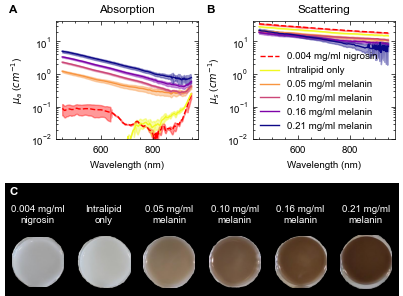

In [8]:
cmap = matplotlib.colormaps["plasma"]

log = False
scale = 1

fig = plt.figure(figsize=(5.25 * 0.75, 5.25 / 3 * 1.7))

subfiga, subfigb = fig.subfigures(2, height_ratios=(2, 1.4))

ax1, ax2 = subfiga.subplots(1, 2)

labels = {
    "A": "Intralipid only",
    "B": "0.004 mg/ml nigrosin",
    "C": "Intralipid only",
    "D": "0.05 mg/ml melanin",
    "E": "0.10 mg/ml melanin",
    "F": "0.16 mg/ml melanin",
    "G": "0.21 mg/ml melanin",
}

colours = {
    "A": (cmap(1.0), None),
    "B": ("r", "--"),
    "C": (cmap(1.0), None),
    "D": (cmap(0.75), None),
    "E": (cmap(0.5), None),
    "F": (cmap(0.25), None),
    "G": (cmap(0.0), None),
}

sample_dfs = []

for folder in folders[:]:
    if "A" in folder:
        continue
    label = folder.split("_")[-1]
    f = load_folder(folder)
    mua = f["mua"]
    delta_mua = f["mua_std"]  # / np.sqrt(3)

    mus = f["mus"]
    delta_mus = f["mus_std"]  # / np.sqrt(3)

    df = pd.DataFrame(dict(f))
    df["Sample"] = label
    sample_dfs.append(df)

    mua *= scale
    delta_mua *= scale

    if log:
        delta_mua = delta_mua / mua / np.log(10)
        mua = np.log10(mua)
        delta_mus = delta_mus / mus / np.log(10)
        mus = np.log10(mus)

    colour, style = colours[label]

    ax1.plot(f["wavelengths"], mua, label=labels[label], c=colour, linestyle=style)
    ax1.fill_between(
        f["wavelengths"], mua - delta_mua, mua + delta_mua, alpha=0.4, color=colour
    )

    ax2.plot(f["wavelengths"], mus, c=colour, linestyle=style)
    ax2.fill_between(
        f["wavelengths"], mus - delta_mus, mus + delta_mus, alpha=0.4, color=colour
    )

ax1.set_xlabel("Wavelength (nm)")
ax1.set_ylabel(r"$\mu_a$ ($cm^{-1}$)")

ax2.set_xlabel("Wavelength (nm)")
ax2.set_ylabel(r"$\mu_s$ ($cm^{-1}$)")

ax1.set_title("Absorption")
ax2.set_title("Scattering")

ax1.set_yscale("log")
ax2.set_yscale("log")
ax2.set_ylim(
    [
        max(min(ax1.get_ylim() + ax2.get_ylim()), 0.01),
        max(ax1.get_ylim() + ax2.get_ylim()),
    ]
)
ax1.set_ylim(
    [
        max(min(ax1.get_ylim() + ax2.get_ylim()), 0.01),
        max(ax1.get_ylim() + ax2.get_ylim()),
    ]
)

subfiga.legend(loc="lower left", frameon=False, bbox_to_anchor=(0.625, 0.2))

# subfiga.subplots_adjust(right=0.99, left=0.125, top=0.9, bottom=0.2, wspace=0.35)

_, subfigb_2 = subfigb.subfigures(2, height_ratios=[0.05, 1], hspace=0)

axes = subfigb_2.subplots(1, len(ims))

labels = {
    "A": "Intralipid only",
    "B": "0.004 mg/ml\nnigrosin",
    "C": "Intralipid\nonly",
    "D": "0.05 mg/ml\nmelanin",
    "E": "0.10 mg/ml\nmelanin",
    "F": "0.16 mg/ml\nmelanin",
    "G": "0.21 mg/ml\nmelanin",
}

for (im, name), ax in zip(ims, axes):
    x, y, z = (230, 230, 4)
    bounding_array = np.full((x, y, z), np.nan)
    im_array = np.array(im).astype(np.float32) / 255
    bounding_array[
        x // 2
        - im_array.shape[0] // 2 : x // 2
        - im_array.shape[0] // 2
        + im_array.shape[0],
        y // 2
        - im_array.shape[1] // 2 : y // 2
        - im_array.shape[1] // 2
        + im_array.shape[1],
    ] = im_array
    ax.imshow(bounding_array)
    ax.set_title(labels[name], color="w", fontsize="medium", pad=10, y=0.95)
    ax.axis("off")
subfigb.set_facecolor("black")
subfigb_2.set_facecolor("black")

l = add_axis_label(ax1, "A")
add_axis_label(ax2, "B")
label_c = add_subfigure_label(subfigb_2, axes[0], "C")
label_c.set_color("w")

plt.savefig("../figures/dis_abs_scattering.png", dpi=300)
plt.savefig("../figures/dis_abs_scattering.pdf", dpi=300)
plt.show()